In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random

from models import network
from utils.Dataset import DatasetLoader

In [2]:
model = network.build_model((448, 448, 3))
model.load_weights('./ckpt/valid_best_yolo')
decoder = network.OutputDecoder()

In [3]:
inputs = model.input
out = decoder(model.output)
final_model = keras.models.Model(inputs, out)

In [4]:
test_path = glob('./dataset/VOCdevkit/VOC2012_test/JPEGImages/*')

In [5]:
def load_sample(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path))
    img = tf.image.resize(img, (448, 448))
    sample = tf.expand_dims(img, axis=0) / 255.
    
    return sample, img.numpy().astype(np.uint8)

In [6]:
class_dict = {
    0: "aeroplane",
    1: "bicycle",
    2: "bird",
    3: "boat",
    4: "bottle",
    5: "bus",
    6: "car",
    7: "cat",
    8: "chair",
    9: "cow",
    10: "diningtable",
    11: "dog",
    12: "horse",
    13: "motorbike",
    14: "person",
    15: "pottedplant",
    16: "sheep",
    17: "sofa",
    18: "train",
    19: "tvmonitor"
}

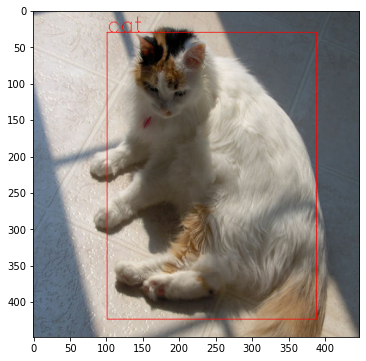

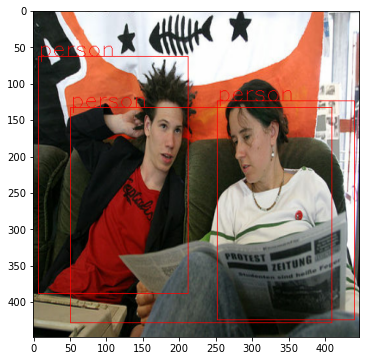

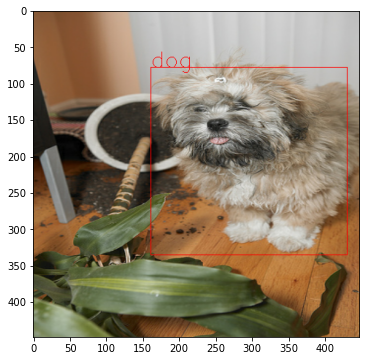

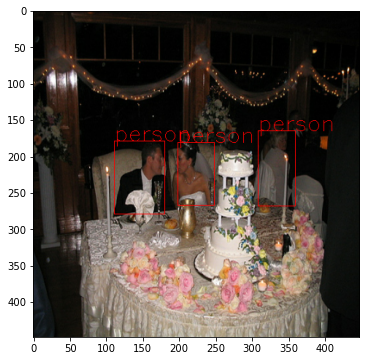

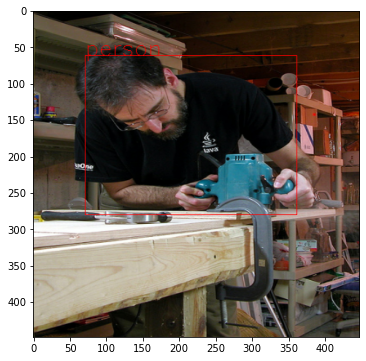

In [68]:
random.shuffle(test_path)
for path in test_path[:5]:
    plt.figure(figsize=(6, 6))
    sample, image = load_sample(path)
    valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample)
    for box, name in zip(nms_boxes[0][:valid_num[0]], nmsed_classes[0][:valid_num[0]]):
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
        image = cv2.putText(image, class_dict[name], pt1, color=(255, 0, 0), fontFace=cv2.FONT_ITALIC, fontScale=1)
        
    plt.imshow(image)
    plt.show()

In [17]:
loader = DatasetLoader('./dataset/train', 448, 7, 20)
train_ds, val_ds = loader.get_dataset(4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


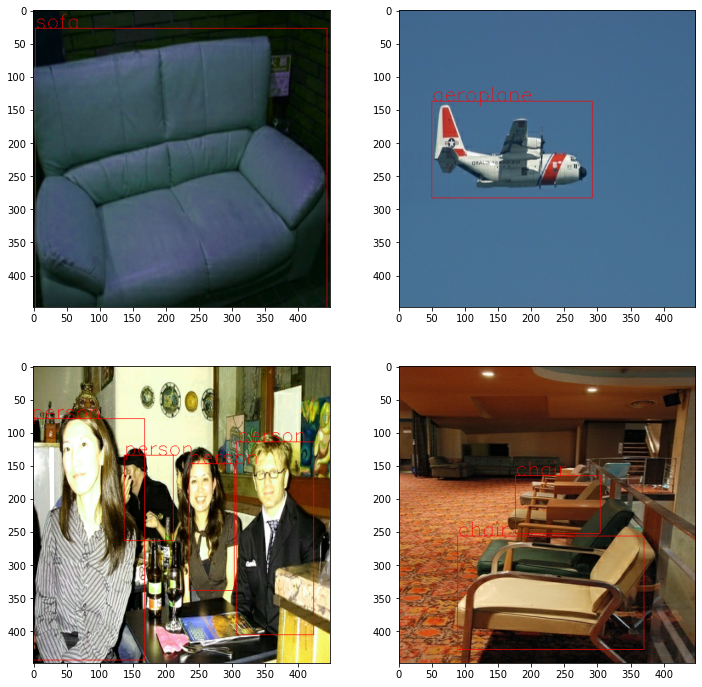

In [24]:
for i in train_ds.take(1):
    sample = i
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy())
    for box, name in zip(nms_boxes[i][:valid_num[i]], nmsed_classes[i][:valid_num[i]]):
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
        image = cv2.putText(image, class_dict[name], pt1, color=(255, 0, 0), fontFace=cv2.FONT_ITALIC, fontScale=1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


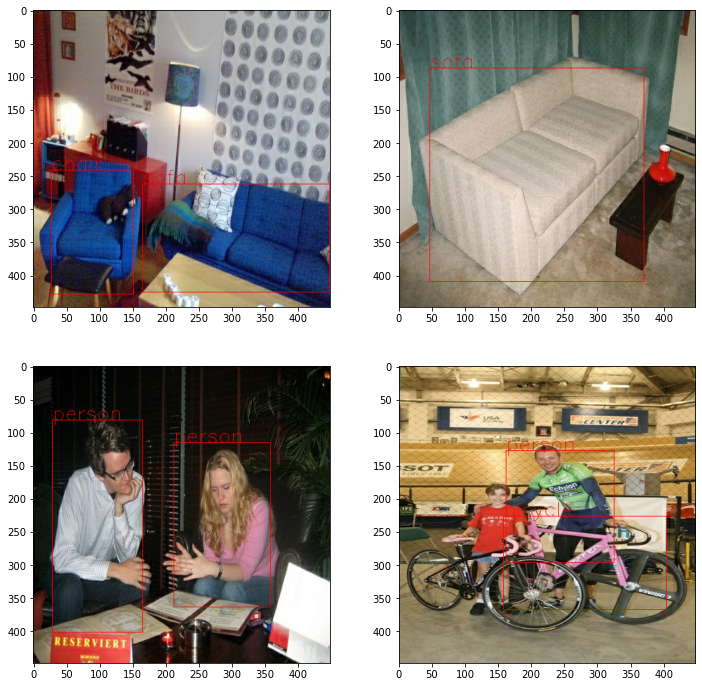

In [45]:
for i in val_ds.take(24):
    sample = i
valid_num, nms_boxes, nms_scores, nmsed_classes = final_model.predict(sample[0])
plt.figure(figsize=(12, 12))
for i in range(4):
    image = (sample[0][i].numpy())
    for box, name in zip(nms_boxes[i][:valid_num[i]], nmsed_classes[i][:valid_num[i]]):
        pt1 = (int(box[1]), int(box[0]))
        pt2 = (int(box[3]), int(box[2]))
        image = cv2.rectangle(image, pt1, pt2, (255, 0, 0), 1)
        image = cv2.putText(image, class_dict[name], pt1, color=(255, 0, 0), fontFace=cv2.FONT_ITALIC, fontScale=1)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)